#Analyzing "Data Scientist" job descriptions

What is "Data Science"?  One way to answer this question is to analyze job descriptions for patterns, and summarize these somehow (such as with clustering or LSI).

We can download pages of job descriptions for 'data scientist' today at stackoverflow.com,
and then scrape the pages for keywords.   This is not hard to do in Python.
We can get hundreds of job listings, from hundreds of employers, in a few seconds.

Each job notice has a set of keywords (terms, buzzwords), often listing the skills
that are most important for the job.  We can use these keywords to make a "term-document"
matrix (actually Employer-Keyword table) that can be analyzed to see which
skills are important at which companies.

D.S. Parker<br/>
May 2015


##Retrieve job notices for 'data scientist' from stackoverflow.com

This Python code is based on a script by Yufei (Benny) Chen, a UCLA alumnus and software wizard.


In [134]:

def stackoverflow_query_url( query_terms ):
    url_query_terms = query_terms.strip().replace(' ','+').replace('"','%22')
    query_prefix = 'http://careers.stackoverflow.com/jobs?searchTerm='
    query_suffix = '&type=any&location=&range=&distanceUnits=Miles'
    query_url = query_prefix + url_query_terms + query_suffix
    return query_url


import time

def stackoverflow_job_text( query_url ):
    html_result = requests.get(query_url)
    html_text = html_result.content
    for pg in range(2,101):  # get 100 pages' worth of job notices
        html_result = requests.get(query_url + '&pg=%d' % pg)  # get the pg'th page
        html_text += html_result.content
        time.sleep(3)  # sleep 3 seconds, to avoid annoying stackoverflow
    return html_text


In [136]:

many_job_query_terms = '"big data" "data science" "data analytics" "data analysis" "machine learning"'

non_data_science_job_query_terms = '-"data science"'  # '-' negates the query

non_data_science_job_query_url = stackoverflow_query_url( non_data_science_job_query_terms )


In [137]:

non_data_science_job_html_text = stackoverflow_job_text( non_data_science_job_query_url )
    
print( len(non_data_science_job_html_text) )  #  print the length of the downloaded text


11852283


##The step above takes a little time -- it downloads 100 pages' worth of job notices.

In [138]:

#### stackoverflow also allows direct query of jobs by a specific tag:
# job_query_url = "http://careers.stackoverflow.com/jobs/tag/machine-learning"
# job_query_url = "http://careers.stackoverflow.com/jobs/tag/big-data"
# job_query_url = "http://careers.stackoverflow.com/jobs/tag/data-analysis"
# job_query_url = "http://careers.stackoverflow.com/jobs/tag/data-analytics"

data_science_job_query_url = "http://careers.stackoverflow.com/jobs/tag/data-science"


In [139]:

data_science_job_html_text = stackoverflow_job_text( data_science_job_query_url )
    
print( len(data_science_job_html_text) )  #  print the length of the downloaded text


13435347


In [140]:
print( data_science_job_html_text[85000 : 86000] )  # print some illustrative lines of the HTML retrieved

jobs/tag/data-science?sort=s">relevance</a>
                </li>
        </ul>
        <div class="tabNav-borderBottom"></div>
</div>


        
<div class="listResults -jobs list jobs">
    <div class="listResults">
        <div data-jobid="80605" class="-item -job">
            <p class="text _small _muted posted top">
                4 weeks ago
                <br/>
                
            </p>

<a class="fav-toggle" data-jobid="80605" href="/jobs/togglefavorite/80605?returnUrl=%2fjobs%2ftag%2fdata-science"></a>            
            <h3 class="-title">
                <a class="job-link" href="/jobs/80605/associate-data-engineer-data-wrangler-seed-scientific?a=r20BToxgc8g&amp;searchTerm=%22data+science%22" title="Associate Data Engineer/Data Wrangler">Associate Data Engineer/Data Wrangler</a>
            </h3>


            <p class="text _small location">
                <strong class="-employer">Seed Scientific</strong>&nbsp;&bull;&nbsp;
              


In [141]:
# Maybe cache the HTML text here...

NERVOUS = False

if (NERVOUS):
   cache = open("cached_non_data_science_html_text.txt", "w")
   cache.write(non_data_science_job_html_text)
   cache.close()

   cache = open("cached_data_science_html_text.txt", "w")
   cache.write(data_science_job_html_text)
   cache.close()


##  parse the HTML using BeautifulSoup

In [142]:
from bs4 import BeautifulSoup
import requests, operator

In [143]:

#  (the current HTML parser cannot handle this input, so we use the old parser here):

data_science_job_soup = BeautifulSoup(data_science_job_html_text, 'html.parser')

print(len(data_science_job_soup))   # number of high-level tags in the parsed HTML


non_data_science_job_soup = BeautifulSoup(non_data_science_job_html_text, 'html.parser')

print(len(non_data_science_job_soup))   # number of high-level tags in the parsed HTML

1200
1200


In [144]:
# utilities used below to omit unicode symbols from the data, and keep only ascii

import unicodedata

def asciify(x):
   try:
      y = x.encode("ascii", 'ignore')
   except:
      y = x.decode("utf-8", 'ignore').encode("ascii", 'ignore')
   return y

def first(list):
    if type(list) != type([]):  return ''
    if len(list) == 0:  return ''
    return list[0].strip()

def first_ascii(list):
    return asciify( first(list) )


# Find the frequencies of job tags

In [145]:
#  dictionary to count the frequencies of each term (= job tag, keyword)

def term_frequency_table(soup):  
    term_frequency = dict()
    for eachJobTagSet in soup.find_all('div', class_ = "tags" ):
        ActualTagSet = [asciify(job_tag.text.replace('-',' ')) for job_tag in eachJobTagSet.find_all('a')]
        for job_tag in ActualTagSet:
            if job_tag in term_frequency:
                term_frequency[job_tag] += 1
            else:
                term_frequency[job_tag] = 1
    return term_frequency


In [146]:
data_science_job_term_frequency = term_frequency_table(data_science_job_soup)

print(len(data_science_job_term_frequency))

580


In [147]:
# sort the resulting keyword dictionary by frequency,
# and print the most frequent in descending order

sorted_data_science_job_terms =  sorted(data_science_job_term_frequency.iteritems(), key=operator.itemgetter(1), reverse=True)

for term, frequency in sorted_data_science_job_terms:
    if frequency > 10:
        print "%s\t%s" % (term, frequency)

data	891
sql	624
hadoop	617
python	534
java	377
networking	217
embedded	204
machine learning	199
hacking	198
javascript	181
linux	180
c++	153
mongodb	147
big	146
amazon web services	136
ruby	134
excel	134
nosql	126
mysql	126
postgresql	120
git	117
oop	112
data warehouse	112
apache spark	108
c#	106
analysis	103
mapreduce	102
computer forensics	102
bigdata	101
ruby on rails 4	100
spark streaming	99
multimedia	99
data modeling	99
os	99
scala	96
.net	82
php	76
etl	75
sysadmin	72
redis	72
spark	69
database administration	67
haskell	66
statistics	65
svm	65
e commerce	63
rds	60
jquery	58
kafka	57
r	57
css	56
storm	55
large data	55
android	52
elastic map reduce	51
pig	50
ruby on rails	49
sql server	49
html	49
xml	47
angularjs	44
html5	42
d3.js	41
ios	40
c	39
data analysis	38
computer vision	37
asp.net	35
xslt	35
modeling	35
rest	30
agile	29
elasticsearch	27
node.js	27
unix	26
go	25
css3	24
asp.net mvc	22
java ee	21
spring	19
hpc	19
mobile	18
storage	18
zfs	17
web services	17
hbase	16
backbone.

In [148]:
N = len(sorted_data_science_job_terms)
print(N)

sorted_data_science_job_terms[0:5]

580


[('data', 891), ('sql', 624), ('hadoop', 617), ('python', 534), ('java', 377)]

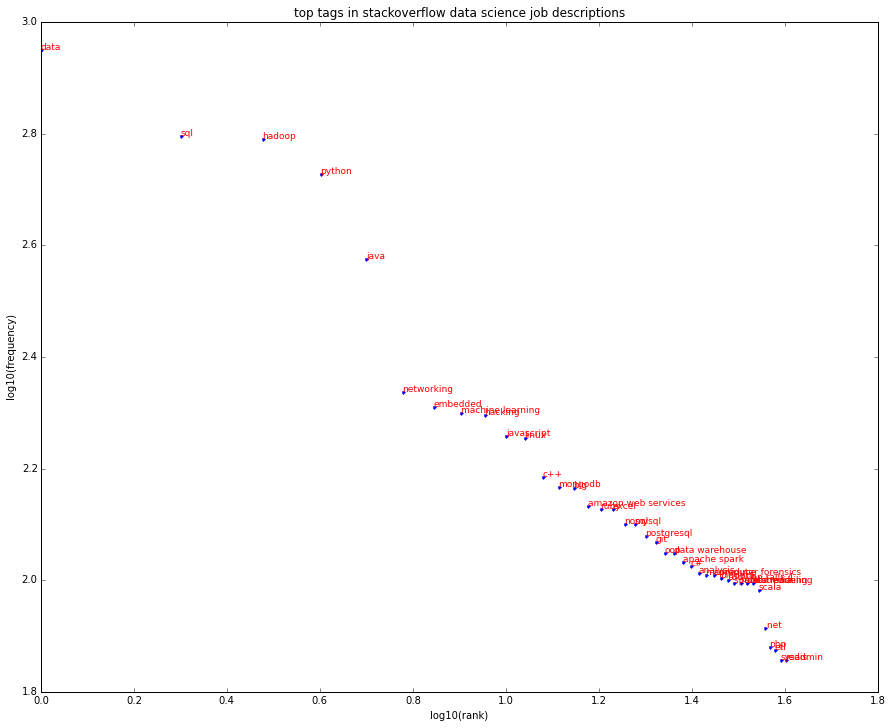

In [149]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.text as txt

plt.rcParams['figure.figsize'] = (15.0, 12.0)
fig, ax = plt.subplots()

import numpy as np

how_many = 40

counts = np.asarray([term_count[1] for term_count in sorted_data_science_job_terms[:how_many]])

strings = ([term_count[0] for term_count in sorted_data_science_job_terms[:how_many]])

plt.plot( np.log10(1+np.arange(how_many)), np.log10(counts), 'b.' )
plt.xlabel( 'log10(rank)' )
plt.ylabel( 'log10(frequency)' )
plt.title( 'top tags in stackoverflow data science job descriptions' )

for rank in range(how_many):
    ax.text( np.log10(1+rank), np.log10(counts[rank]), strings[rank], color='red', fontsize=9)
    
plt.show()

In [150]:

non_data_science_job_term_frequency = term_frequency_table(non_data_science_job_soup)

print(len(non_data_science_job_term_frequency))

sorted_non_data_science_job_terms =  sorted(non_data_science_job_term_frequency.iteritems(), key=operator.itemgetter(1), reverse=True)


692


In [156]:
TagsThatAppearMoreThan10Times  = set([ k for k,n in sorted_data_science_job_terms if n > 10 ])
TagsThatAppearMoreThan10Times.update([ k for k,n in sorted_non_data_science_job_terms if n > 10 ])

TagsThatAppearMoreThan10Times = list(TagsThatAppearMoreThan10Times)

print(len(TagsThatAppearMoreThan10Times))


127


In [157]:
print(TagsThatAppearMoreThan10Times)


['frontend', 'nosql', 'excel', 'rest', 'kafka', 'node.js', 'mysql', 'go', 'hbase', 'xml', 'agile', 'selenium', 'lamp', 'd3.js', 'user interface', 'networking', 'multithreading', 'css3', 'data modeling', 'data warehouse', 'python', 'big', 'java ee', 'e commerce', 'spark streaming', '.net', 'ruby on rails', 'c++', 'api', 'architecture', 'spring', 'linux', 'scrum', 'mapreduce', 'chef', 'analytics', 'hibernate', 'backbone.js', 'windows', 'scala', 'multimedia', 'redis', 'bigdata', 'large data', 'web services', 'data analysis', 'xslt', 'javascript', 'tdd', 'maven', 'ajax', 'statistics', 'html5', 'model view controller', 'modeling', 'spark', 'swift', 'bash', 'c', 'postgresql', 'rds', 'drupal', 'symfony2', 'mvc', 'elasticsearch', 'elastic map reduce', 'os', 'etl', 'objective c', 'data science', 'unix', 'haskell', 'puppet', 'computer forensics', 'git', 'java', 'perl', 'asp.net mvc', 'json', 'wordpress', 'storm', 'ruby on rails 4', 'testing', 'open source', 'c#', 'apache spark', 'oop', 'ruby', '

##Tag/Keyword Feature Vectors

In [158]:

def feature_vector(InputFeatureList, ListOfImportantFeatures):
    n = len( ListOfImportantFeatures )
    feature_vector = [0] * n
    for i in range(n):
        if ListOfImportantFeatures[i] in InputFeatureList:
            feature_vector[i] += 1
    return feature_vector


In [388]:

important_tag_features = TagsThatAppearMoreThan10Times


def tag_feature_vector( KeywordList ):
    return  feature_vector( KeywordList, important_tag_features )

example = tag_feature_vector( ['python', 'r', 'javascript', 'very rare feature', 'data science'] )
print(example)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [389]:

import string
def tag_name(s):
    return (s.translate(None, string.punctuation).replace(' ','_') + '_tag')
    # delete punctuation, and replace ' ' by '_'


important_tag_features_names = [tag_name(f) for f in important_tag_features]


##Extract features from each job title

In [390]:
# edits (of job title text)

useful_job_title_edits = [
    ('c++', 'cplusplus'), ('c#', 'csharp'), ('.net', 'dotnet'), 
    ('.', ''), (',', ''), ('.', ''), ('!', ''), ('?', ''), ('&', ''), ('@', ''), (':', ''), ('|', ''),
    ('*', ' '), ('/', ' '), ('+', ' '), ('-', ' '), ('_', ' '),
    ('"', ''), ("'s", ''), ("'", ''), ('  ',' '), ('  ',' '), ('  ',' '),
    ('administrateur', 'administrator'), ('anwendungs', 'application'), ('analyse', 'analysis'),
    ('app', 'application'), ('applications', 'application'), ('apps', 'application'),
    ('back end', 'back_end'), ('backend', 'back_end'),
    ('bi', 'businessintelligence'), ('big data', 'big_data'), ('business intelligence', 'business_intelligence'),
    ('data analyst', 'data_analysis'), ('data analysis', 'data_analysis'),
    ('data wrangler', 'data_wrangling'), ('data wrangling', 'data_wrangling'),
    ('data science', 'data_science'), ('data scientist', 'data_science'),
    ('data research scientist', 'data_science research'), ('entwickler', ' development'),
    ('devops', 'development operations'), ('developers', 'development'), ('developer', 'development'),
    ('dev ', 'development '), ('engineering', 'engineer'), ('engineers', 'engineer'),
    ('front end', 'front_end'), ('frontend', 'front_end'),
    ('full stack', 'full_stack'), ('fullstack', 'full_stack'), ('ingenieur', 'engineer'), ('jr', 'junior'),
    ('machine learning', 'machine_learning'),
    ('sr', 'senior'), ('ruby on rails', 'ruby'), ('rails', 'ruby'), ('scalable', 'scalability'),
    ('service', 'web_service'), ('sw', 'software'), ('systemadministrator', 'operations'), ('testing', 'test'),
    ('cplusplus', 'c++'), ('csharp', 'c#'), ('dotnet', '.net')]

def edited_job_title_text(TitleText):
    T = TitleText.lower()
    for pattern,replacement in useful_job_title_edits:
        T = T.replace(pattern,replacement)
    return T


In [391]:
# features (appearing as words in the title text)

important_title_features = [
    'administrator', 'analyst', 'analytics', 'android', 'api', 'application', 'architect', 'back_end',
    'big_data', 'business_intelligence', 'cloud', 'data', 'data_analysis', 'database', 'data_science',
    'data_wrangling', 'dba', 'development', 'director', 'embedded',
    'engineer', 'enterprise', 'etl', 'front_end', 'full_stack', 'hadoop', 'head', 'infrastructure',
    'ios', 'java', 'javascript', 'junior', 'lead', 'machine_learning', 'linux', 'manager', 'mobile',
    'mysql', 'network', 'operations', 'php', 'principal', 'product', 'programmer', 'python',
    'quality', 'reliability', 'research', 'ruby', 'saas', 'scala', 'scalability', 'search', 'security',
    'senior', 'sensors', 'software', 'sql', 'startup', 'technical', 'technology', 'test',
    'visualization', 'warehouse', 'web', 'web_services']


def job_title_features_found_in(TitleInformation):
    TitleWords = set(TitleInformation.split(' '))
    features_found = []
    for term in important_title_features:
        if term in TitleWords >= 0:
            features_found += [term]
    return features_found


def job_title_features(TitleText):
    return job_title_features_found_in( edited_job_title_text( TitleText ) )

example = job_title_features( '... data science ... ETL ... full-stack ... bizarre ...' )
print(example)


['data_science', 'etl', 'full_stack']


In [392]:
def job_title_feature_vector(JobTitleFeatures):
    return feature_vector( JobTitleFeatures, important_title_features )


example = job_title_feature_vector( ['data_science', 'etl', 'full_stack'] )
print(example)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [393]:
# extract title and subtitle from title text

def title_and_subtitle(TitleText):
    title = TitleText
    subtitle=''
    for splitstring in [' (', ' - ', ' -', '- ', ' in ', ',']:
        if title.find(splitstring)>0:
            split_position = title.find(splitstring)
            subtitle = asciify(title[(split_position+len(splitstring)):]).strip().replace(')','')
            title = asciify(title[0:split_position]).strip()
            break
    return (title, subtitle)


##Extract Company and Location from Employer Text

In [429]:
def all_up_to(string, pattern):
    n = string.find(pattern)
    if (n<0): return string
    return string[0:n].strip()

def without_punctuation(s):
    return s.translate(None, string.punctuation).replace('  ',' ').replace(' ','_')

def without_suffix(s):
    t = s
    for suffix in ['INC','Inc','Company','LLC','Llc','LP','Ltd','LTD','GmbH','gmbh','mbH',
                   'PLC','Plc','plc','AG','SA','SL','KG','UG','KGaA']:
        if t.endswith(suffix):
            t = t.replace('_'+suffix,'')
    return t

def employer_and_location(EmployerText):
    employer_location =  [x.strip() for x in first_ascii(EmployerText).split('\n')]
    employer = employer_location[0].strip()
    employer = all_up_to(employer,',')
    employer = all_up_to(employer,' -')
    employer = all_up_to(employer,'|')
    employer = all_up_to(employer,'(')
    location = employer_location[1]
    return (without_suffix(without_punctuation(employer)), location)


#Print a table of information summarizing the job descriptions

The table includes:
<ul>
<li>Job Title</li>
<li>Job Subtitle (if there is one)</li>
<li>List of Title features (keywords)</li>
<li>Employer</li>
<li>Employer Location</li>
<li>JobID</li>
<li>(whether remote work is possible or not)</li>
<li>(whether relocation is covered or not)</li>
<li>Descriptive Keywords/Buzzwords -- usually Skills</li>
</ul>

In [430]:

job_divs = job_soup.find_all('div', class_ = "-job" )
print(len(job_divs))  #  number of HTML <div>s for job postings


2500


In [431]:
def job_table(soup):
    JobTable = []
    
    JobIDs = set([])
    for eachJob in soup.find_all('div', class_ = "-job" ):
   
        jobid = asciify(eachJob.get('data-jobid', ''))
        if jobid in JobIDs:
            continue
        JobIDs.add(jobid)
        
        titleText = first_ascii([x.text for x in eachJob.find_all('h3', class_ = "-title")])
        title, subtitle = title_and_subtitle(titleText)
        title_features = job_title_features(titleText)
    
        employerText = [x.text.lstrip('\n') for x in eachJob.find_all('p', class_ = "text _small location")]
        employer, location = employer_and_location(employerText)
    
        remote = ("no" if (first_ascii([x.text for x in
                               eachJob.find_all('span', class_ = "badge -remote _inline")])  == '')
                  else "yes")
        relocation = ("no" if (first_ascii([x.text for x in
                                   eachJob.find_all('span', class_ = "badge -relocation _inline")])  == '')
                      else "yes")
   
        keyword_list = [asciify(x.text).replace('-',' ')
                            for x in eachJob.find_all('a', class_ = "post-tag job-link")]
        keyword_count = len(keyword_list)
        
        JobTable += [[title, subtitle, title_features, employer, location,
                      jobid, remote, relocation, keyword_count, keyword_list]]
    
    return JobTable

In [432]:
DataScienceJobTable = job_table(data_science_job_soup)

len(DataScienceJobTable)

634

In [433]:
NonDataScienceJobTable = job_table(non_data_science_job_soup)

len(NonDataScienceJobTable)

1016

##Explore the Table of Job Postings -- as a List of Lists in Python

In [434]:
len(DataScienceJobTable[0])  # Table is a list of "rows"; each row is a list of length 10.

10

In [435]:
DataScienceJobTable[0]  # the first row in the table

['Associate Data Engineer/Data Wrangler',
 '',
 ['data', 'data_wrangling', 'engineer'],
 'Seed_Scientific',
 'New York, NY',
 '80605',
 'no',
 'no',
 2,
 ['python', 'sql']]

In [436]:
DataScienceJobTable[0:2]  # the first 2 rows

[['Associate Data Engineer/Data Wrangler',
  '',
  ['data', 'data_wrangling', 'engineer'],
  'Seed_Scientific',
  'New York, NY',
  '80605',
  'no',
  'no',
  2,
  ['python', 'sql']],
 ['Scalable Machine Learning Infrastructure Engineer',
  '',
  ['engineer', 'infrastructure', 'machine_learning', 'scalability'],
  'Realeyes',
  'Budapest, Hungary',
  '88096',
  'no',
  'yes',
  5,
  ['python', 'machine learning', 'spark', 'hadoop', 'svm']]]

##pandas : a better Table interface for Python

In [437]:
import pandas as pd

In [438]:
Table = DataScienceJobTable + NonDataScienceJobTable

In [439]:
JobDataFrame = pd.DataFrame({
    'Title' : [t[0] for t in Table],
    'TitleDetails' : [t[1] for t in Table],
    'TitleFeatures' : [t[2] for t in Table],
    'Employer' : [t[3] for t in Table],
    'Location' :    [t[4] for t in Table],
    'JobID' : [t[5] for t in Table],
    'RemoteWork' : [t[6] for t in Table],
    'Relocate': [t[7] for t in Table],
    'KeywordCount' : [t[8] for t in Table],
    'KeywordList' : [t[9] for t in Table],
    'dataScienceJob' : (['yes'] * len(DataScienceJobTable)) + (['no'] * len(NonDataScienceJobTable)) })


##Write out the job data frame to "JobDataFrame.tsv"

In [440]:

JobDataFrame.to_csv('JobDataFrame.tsv', sep='\t', header=True)

print(JobDataFrame.shape)   # display the size of the table


(1650, 11)


##pandas implements data frames in Python, and can take advantage of web browser interfaces

In [441]:
JobDataFrame[0:5]

,Employer,JobID,KeywordCount,KeywordList,Location,Relocate,RemoteWork,Title,TitleDetails,TitleFeatures,dataScienceJob
0,Seed_Scientific,80605,2,"[python, sql]","New York, NY",no,no,Associate Data Engineer/Data Wrangler,,"[data, data_wrangling, engineer]",yes
1,Realeyes,88096,5,"[python, machine learning, spark, hadoop, svm]","Budapest, Hungary",yes,no,Scalable Machine Learning Infrastructure Engineer,,"[engineer, infrastructure, machine_learning, s...",yes
2,SumAll,85469,5,"[python, java, haskell, hadoop, mongodb]","New York, NY",no,no,Data Engineer,,"[data, engineer]",yes
3,Narrative_Science,83690,5,"[postgresql, mongodb, redis, database administ...","Chicago, IL",no,no,Data Architect/DBA,,"[architect, data, dba]",yes
4,Barricadeio,83343,5,"[kafka, storm, hadoop, statistics, large data]","Cork Airport Business Park, Ireland",yes,no,Data Science Engineer,,"[data_science, engineer]",yes


In [442]:
JobDataFrame[ JobDataFrame.Employer == 'Amazon' ]

,Employer,JobID,KeywordCount,KeywordList,Location,Relocate,RemoteWork,Title,TitleDetails,TitleFeatures,dataScienceJob
28,Amazon,88120,4,"[hadoop, big, data, os]","Dublin, Ireland",yes,no,Big-Data Devops Support Engineer,- Amazon Web Services,"[data, development, engineer, operations, web,...",yes
36,Amazon,87482,2,"[statisitcal, analysis]","Seattle, WA",yes,no,Senior Data/ Research Scientist,,"[data_science, research, senior]",yes
46,Amazon,88256,3,"[sql, r, sas]","Seattle, WA",yes,no,Business Intelligence Engineer,,"[business_intelligence, engineer]",yes
52,Amazon,87389,4,"[4, years, of, java]","Newark, NJ",yes,yes,Software Development Engineer,,"[development, engineer, software]",yes
53,Amazon,87674,4,"[4, years, of, java]","Newark, NJ",yes,no,Software Development Engineer,,"[development, engineer, software]",yes
92,Amazon,88189,3,"[c, c++, java]","Seattle, WA",yes,no,Senior Software Development Engineer,,"[development, engineer, senior, software]",yes
99,Amazon,88099,3,"[java, c++, c]","Seattle, WA",yes,no,Software Development Manager,,"[development, manager, software]",yes
142,Amazon,87398,5,"[coding, in, c, c++, java]","Irvine, CA",yes,yes,Mobile Development Engineer,,"[development, engineer]",yes
229,Amazon,87489,3,"[sde, experience, video]","Seattle, WA",yes,no,SDE,"Instant Video: Machine Learning, Mobile, Web, ...","[machine_learning, web]",yes
231,Amazon,87506,1,[see],"Seattle, WA",yes,no,"Software Development Engineer, Customer Interests","Big Data, NLP, Data Mining, Ontologies","[data, development, engineer, software]",yes


In [443]:
JobDataFrame[['Title']] [0:5]  #  look at the 'Title' column in the first 5 rows (as a DataFrame)

,Title
0,Associate Data Engineer/Data Wrangler
1,Scalable Machine Learning Infrastructure Engineer
2,Data Engineer
3,Data Architect/DBA
4,Data Science Engineer


In [444]:
JobDataFrame[0:5].Title  #  look at the 'Title' column in the first 5 rows (as a Series)

0                Associate Data Engineer/Data Wrangler
1    Scalable Machine Learning Infrastructure Engineer
2                                        Data Engineer
3                                   Data Architect/DBA
4                                Data Science Engineer
Name: Title, dtype: object

In [445]:
JobDataFrame.Title[0:5]   #  likewise

0                Associate Data Engineer/Data Wrangler
1    Scalable Machine Learning Infrastructure Engineer
2                                        Data Engineer
3                                   Data Architect/DBA
4                                Data Science Engineer
Name: Title, dtype: object

##Pandas also supports SQL-like queries

In [446]:

#   project on Employer and JobID columns
#     group by Employer
#       count jobIDs per Employer
#         order results by this count, in descending order
#           show the top 20 results

EmployerStats = JobDataFrame[['Employer','dataScienceJob','JobID']].groupby(['Employer','dataScienceJob']).count().sort('JobID', ascending=False)
EmployerStats.head(20)


,,JobID
Employer,dataScienceJob,
Bloomberg,yes,16
Amazon,yes,15
Docler_Holding_Luxembourg,no,10
Bookingcom,yes,9
Pivotal_Labs,no,9
Capital_One,yes,9
Box,yes,9
Lazada,no,8
ThoughtWorks,no,8


##Compute the Job Feature classification Table

In [447]:

UngroupedEmployers = EmployerStats.reset_index()[['Employer']]

Employers = UngroupedEmployers.values.flatten().tolist()

print(Employers[0:20])


['Bloomberg', 'Amazon', 'Docler_Holding_Luxembourg', 'Bookingcom', 'Pivotal_Labs', 'Capital_One', 'Box', 'Lazada', 'ThoughtWorks', 'PayPal', 'TomTom', 'Gears_of_Leo', 'HERE', 'iHerb', 'Amazon', 'Xamarin', 'Idean', 'ROBLOX', 'INRIX', 'Jane_Street']


In [448]:

JobFeatures = [[JobDataFrame.JobID[i], JobDataFrame.Employer[i]] +
               job_title_feature_vector(JobDataFrame.TitleFeatures[i]) +
               tag_feature_vector(JobDataFrame.KeywordList[i]) +
               [('DS' if (JobDataFrame.dataScienceJob[i] == 'yes') else 'nonDS')]
               for i in range(JobDataFrame.shape[0])]

print(JobFeatures[0:2])


[['80605', 'Seed_Scientific', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'DS'], ['88096', 'Realeyes', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [449]:
# convert JobFeatures into a data frame and transpose it,
# so we can name the rows as features, and transpose back.

FeatureDF = pd.DataFrame(JobFeatures).T


# set the feature names
FeatureDF.index = ['JobID', 'Employer'] + \
                  important_title_features + \
                  important_tag_features_names + \
                  ['class']

JobClassificationDataFrame = FeatureDF.T  # transpose back

print(JobClassificationDataFrame[0:2])

   JobID         Employer administrator analyst analytics android api  \
0  80605  Seed_Scientific             0       0         0       0   0   
1  88096         Realeyes             0       0         0       0   0   

  application architect back_end  ...  php_tag data_tag svm_tag sass_tag  \
0           0         0        0  ...        0        0       0        0   
1           0         0        0  ...        0        0       1        0   

  sql_server_tag mobile_tag analysis_tag django_tag docker_tag class  
0              0          0            0          0          0    DS  
1              0          0            0          0          0    DS  

[2 rows x 196 columns]


In [450]:

JobClassificationDataFrame.to_csv('JobClassificationDataFrame.csv', sep=',', header=True)

print(JobClassificationDataFrame.shape)   # display the size of the table


(1650, 196)


##That's it!  Now:  convert JobClassificationDataFrame into a "job classifier"

The column named 'dataScienceJob' is the classification given for each job.
(This classification has been determined by stackoverflow.)
Your job is to build an accurate classifier.

Once you have a classifier, you must upload a Python program that executes it.
This is easy to do in Python:  you simply "pickle" the classifier model structure,
save it in a program, and have the program execute the pickled version.

#Extra Material, in case it helps

##A little more Exploration of the Data

In [451]:

EmployerTagFeatures = [(e,tag_feature_vector(
                              [tag for keyword_list in 
                               JobDataFrame[ JobDataFrame.Employer == e ].KeywordList
                               for tag in keyword_list]))
                          for e in Employers]

print(EmployerTagFeatures[0:2])


[('Bloomberg', [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]), ('Amazon', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])]


In [452]:

EmployerTitleFeatures = [(e,job_title_feature_vector(
                               [f for feature_list in 
                                JobDataFrame[ JobDataFrame.Employer == e ].TitleFeatures
                                for f in feature_list]))
                            for e in Employers]

print(EmployerTitleFeatures[0:2])


[('Bloomberg', [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]), ('Amazon', [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1])]


In [453]:

EmployerFeatures = [(e, Tags+Titles)  #  combine Tag and Title Features into one feature vector
                    for eTags, eTitles in zip( EmployerTagFeatures, EmployerTitleFeatures )
                    for e,Tags in [eTags]
                    for e,Titles in [eTitles]]

print(EmployerFeatures[0:2])


[('Bloomberg', [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]), ('Amazon', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

##Compute the Employers vs. Features data frame

In [454]:
EFdict = dict(EmployerFeatures)

Features_vs_Employers = pd.DataFrame(EFdict)
Features_vs_Employers.index = important_tag_features_names + important_title_features

print(Features_vs_Employers.shape)

Features_vs_Employers[0:2]


(193, 1117)


,,100grams,11_Internet,15Five,1StudentBody,2C2P,2U,3D_MarComms,42reports,500friends,...,tsu,tyntec,uShip,ubitricity_Gesellschaft_fr_verteilte_Energiesysteme,vi,viagogo,webqem,wwwplanetartcom,zanox,zulily
frontend_tag,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
nosql_tag,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [455]:
Employers_vs_Features = Features_vs_Employers.T   # transpose of Features_vs_Employers

print(Employers_vs_Features.shape)

Employers_vs_Features[0:3]

(1117, 193)


,frontend_tag,nosql_tag,excel_tag,rest_tag,kafka_tag,nodejs_tag,mysql_tag,go_tag,hbase_tag,xml_tag,...,software,sql,startup,technical,technology,test,visualization,warehouse,web,web_services
,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100grams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11_Internet,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#Performing PCA on Employers vs. Features in R

In [456]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [460]:
%%R -i Employers_vs_Features

# pass the Employers vs. Features data from Python to R

print(dim(Employers_vs_Features))

print(colnames(Employers_vs_Features)[1:30])
print(rownames(Employers_vs_Features)[1:30])

[1] 1117  191
 [1] "frontend_tag"        "nosql_tag"           "excel_tag"          
 [4] "rest_tag"            "kafka_tag"           "nodejs_tag"         
 [7] "mysql_tag"           "go_tag"              "hbase_tag"          
[10] "xml_tag"             "agile_tag"           "selenium_tag"       
[13] "lamp_tag"            "d3js_tag"            "user_interface_tag" 
[16] "networking_tag"      "multithreading_tag"  "css3_tag"           
[19] "data_modeling_tag"   "data_warehouse_tag"  "python_tag"         
[22] "big_tag"             "java_ee_tag"         "e_commerce_tag"     
[25] "spark_streaming_tag" "net_tag"             "ruby_on_rails_tag"  
[28] "c_tag"               "api_tag"             "architecture_tag"   
 [1] ""                                      
 [2] "100grams"                              
 [3] "11_Internet"                           
 [4] "15Five"                                
 [5] "1StudentBody"                          
 [6] "2C2P"                                  


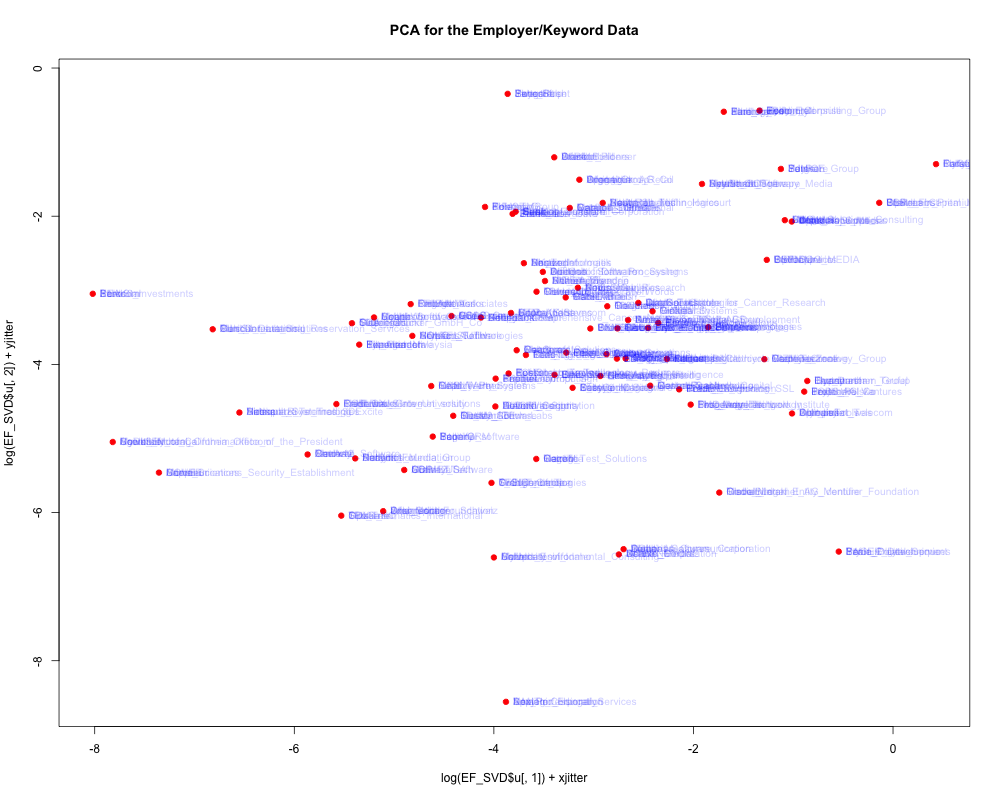

In [458]:
%%R -w 1000 -h 800

## PCA on the Employer/Keyword Data

NonZeroVariance = (apply(Employers_vs_Features, 2, var) != 0)

EF = Employers_vs_Features[, NonZeroVariance]

EF_SVD = svd(cor(EF))
xjitter = rnorm( nrow(EF_SVD$u), 0, 1 )
yjitter = rnorm( nrow(EF_SVD$u), 0, 1 )

plot(log(EF_SVD$u[,1])+xjitter, log(EF_SVD$u[,2])+yjitter,
     pch=20, col="red", cex=1.5, main="PCA for the Employer/Keyword Data")

text(log(EF_SVD$u[,1])+xjitter, log(EF_SVD$u[,2])+yjitter,
     rownames(EF), pos=4, col=adjustcolor("blue",alpha.f=0.2), cex=0.85)  #  add Employer names



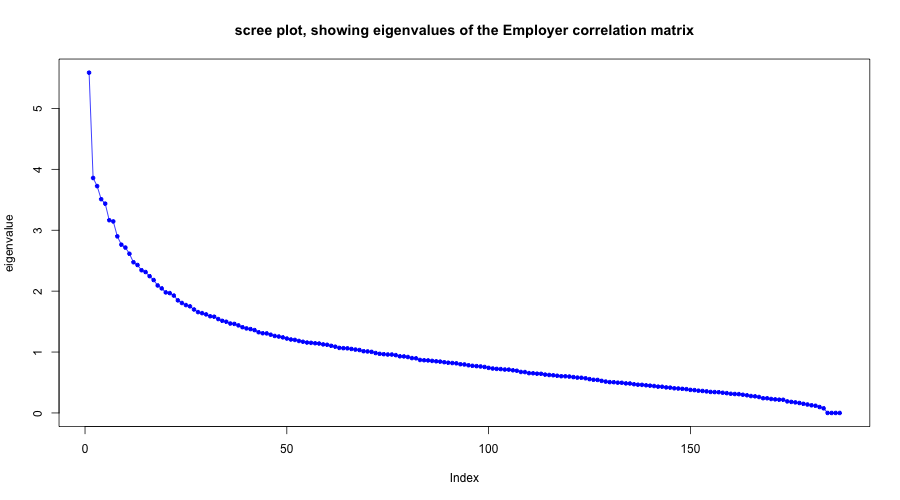

In [459]:
%%R -w 900 -h 500

plot(EF_SVD$d, type="o", pch=20, col="blue",
     ylab="eigenvalue",
     main="scree plot, showing eigenvalues of the Employer correlation matrix")